In [ ]:
#hide
from utilities.ipynb_docgen import *
from nbdev import *

# Analyses

> Ongoing analyses


**`light_curves` library functions used here**
- `get_cells`
- `simulate_cells`
- `get_lightcurve`
- `get_bb_partition`
- `partition_cells`
- `fit_cells`
- `flux_plot`


## Introduction

This notebook does not produce a module to add to the library, it a place to run, and report on analyses using the library. It uses local code, shown below.

This is also an exploration of this style of presenting code, and data analysis based on it.

## Geminga analyses

Following Kerr's example, we use the source Geminga to check that this analysis of data gives results consistent with its being constant. As you can see below, the BB analysis finds 16 breaks, which merit further checks. That is followed by a simulation using
Geminga's weight distribution and exposure. The run shown here finds one minor break, a change of 0.1%. 

**Local code**

In [ ]:
#collapse-hide
from light_curves.config import *
from light_curves.bayesian import *
from light_curves.simulation import *
from light_curves.lightcurve import *
from light_curves.cells import *

def bb_overplot(config, lc, bb_fit, ax=None,  **kwargs):
    fig, ax = plt.subplots(1,1, figsize=(12,4)) if not ax else (ax.figure, ax)
    flux_plot(config, lc, ax=ax, colors=(('lightblue', 'sandybrown', 'blue')),**kwargs)
    flux_plot(config, bb_fit, ax=ax, step=True, **kwargs)
    
def simulation(config, source, bb_key=None):
    """Create and analyze a a simulation for the source
    Returns the simulated, and fit light curves
    """

    lc = get_lightcurve(config, source)
    data_cells = get_cells(config, source)

    #  Get the rate from the data
    cq = data_cells.query('e>0.3')
    T, N = np.sum(cq.tw), np.sum(cq.n)
    sflux=lambda t: N/T

    # simulate, then fit cells to create a simulated light curve 
    sim_cells = simulate_cells(config, source, source_flux=sflux  )
    sim_lc  = fit_cells(config, sim_cells) 

    sim_edges = get_bb_partition(config, sim_lc,  key=bb_key) #'simulated_BB_partition_Geminga') 

    # partion, then fit the cells according to the edges
    sim_bb_cells = partition_cells(config, sim_cells, sim_edges);
    sim_bb_fit  = fit_cells(config, sim_bb_cells, )
    return sim_lc, sim_bb_fit

def analyze_data(config, source):
    """
    Analyze data from the source
    
    Returns, data a partitioned light curves
    """
    lc = get_lightcurve(config, source)
    cells = get_cells(config, source)
    edges = get_bb_partition(config, lc, LikelihoodFitness, key='bb-Geminga-test') 
    bb_cells = partition_cells(config, cells, edges);
    bb_lc  = fit_cells(config, bb_cells, )
    return lc, bb_lc

def fit_table(lc, expect=1.0):
    """Generate a summary table from a light curve"""
    fits = lc.fit
    flux = fits.apply(lambda f: f.flux)
    errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), round(f.errors[1]-f.flux ,3) ) )
    sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
    df = lc['t tw n'.split()].copy() # maybe fix warnings?
    df.loc[:,'flux'] = flux.values.round(4)
    df.loc[:, 'errors'] = errors.values
    df.loc[:, 'sigma_dev'] = sigma_dev.values
    return df

In [ ]:
config = Config()
source = PointSource('Geminga')
cells = get_cells(config, source)
lc = get_lightcurve(config, source)

Cell data for Geminga: Restoring from cache with key "cells_Geminga"
Light curve for Geminga: Restoring from cache with key "lightfcurve_Geminga"


In [ ]:
cells.S/cells.B

0       1.966618
1       1.966618
2       1.966618
3       1.966618
4       1.966618
          ...   
4010    1.966618
4011    1.966618
4012    1.966618
4013    1.966618
4014    1.966618
Length: 4015, dtype: float64

In [ ]:
lc.iloc[0]

t                             54683.5
tw                                  1
n                                 330
e                             1.26456
fit      0.927[1+0.076-0.079], < 1.05
Name: 0, dtype: object

In [ ]:
c0 =cells.iloc[0]
(c0.S)/(c0.n)

0.683592106544127

In [ ]:
x = lc.iloc[0];
print( x.fit.poiss.p)
norm = lc.fit.apply(lambda t: t.poiss.p[1]).values

[0.926896278769946, 213.44333054523736, 0.1670704555639128]


In [ ]:
r = norm/lc.n.values
r.mean()

0.6302296943365991

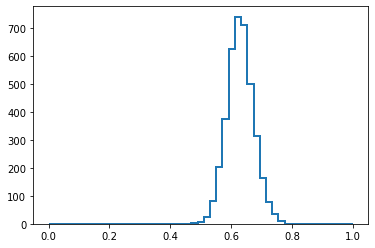

In [ ]:
#plt.hist(norm, np.linspace(100,300), histtype='step', lw=2);
plt.hist (r, np.linspace(0,1), histtype='step', lw=2);

In [ ]:
#collapse-hide
def analysis_plots(name, expect=0.990, simname=''):
    """
    #### {sim} Geminga data
    
    Get, or simulate, the daily binned data, or cells; perform Bayesian Blocks partition;
    make fits to the blocks. <br>(Run at {date})
    
    {output}
    
    This shows the fits to all cells, with the BB fit overlays
    {fig1}
    
    Since this is a constant source, there should be no breaks, that is, only one partition.
    Here is a table of the partition fits:
    
    {df_text}
    The last column represents the compatibility of the flux measurement for each partition
    with the expected value {expect} in equivalent sigma units.
    
    Expand the plot around short, < 100 day partitions.
    {short_check}
    
    {fig2}
    """
    config = Config()
    source = PointSource(name)
    simulated = bool(simname)
    sim= 'Simulated' if simulated else ''
    with capture_print('Analysis output' ) as output:
        if not simulated:
            lc, bb_lc = analyze_data(config, source)
        else: 
            lc, bb_lc = simulation(config, source, bb_key=simname) 

    pd.set_option('display.precision', 3)#, 'display.colheader_justify','left')
    expect
    df = fit_table(bb_lc, expect=expect)
    df_text = monospace(str(df), 'BB fit table', open=True)
        
    plt.rc('font', size=16)
    fig1, ax = plt.subplots(1,1, sharex=True, figsize=(10,4), num=1)
    bb_overplot(config, lc, bb_lc, ax = ax)
    ax.text(0.05, 0.85, name,  transform=ax.transAxes);
    fig1.width=600

    bb_short = bb_lc.query('tw<100'); ns =len(bb_short)
    if ns>0:
        short_check=f'There are {ns} such.'
        rows = (ns+1)//3
        fig2, axx = plt.subplots(3, rows, figsize=(15, 4*rows),sharey=True, sharex=True,
                     gridspec_kw=dict(top=0.85, left=0.08, bottom=0.15, hspace=0.2 ),num=2)
        fig2.width=600
        for t, ax in zip(bb_short.t, axx.flatten()):
            bb_overplot(config, lc, bb_lc, ax=ax, tzero=t, xlim=(-50, +50))
    else:
        fig2=''
        short_check = 'None found.'
    return locals()

if Config().valid:
    nbdoc(analysis_plots, 'Geminga')

####  Geminga data

Get, or simulate, the daily binned data, or cells; perform Bayesian Blocks partition;
make fits to the blocks. <br>(Run at 2020-12-24 08:56)

<details  class="nbdoc-description" >  <summary> Analysis output </summary>  <div style="margin-left: 5%"><pre>Light curve for Geminga: Restoring from cache with key "lightfcurve_Geminga"<br>Cell data for Geminga: Restoring from cache with key "cells_Geminga"<br>BB edges for...: Restoring from cache with key "bb-Geminga-test"<br>Partitioned 3873 cells into 11 blocks, using LikelihoodFitness <br>Loaded 11 / 11 cells with exposure &gt; 0.3 for fitting<br></pre></div> </details>

This shows the fits to all cells, with the BB fit overlays
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/analysis_plots_fig_01.png" title="images/analysis_plots_fig_01.png">    <img src="images/analysis_plots_fig_01.png" alt="Figure 1 at images/analysis_plots_fig_01.png" width=600>   </a> </figure>
</div>


Since this is a constant source, there should be no breaks, that is, only one partition.
Here is a table of the partition fits:

<details open class="nbdoc-description" >  <summary> BB fit table </summary>  <div style="margin-left: 5%"><pre>          t      tw       n   flux           errors  sigma_dev<br>0   55027.5   689.0  208105  0.999  (-0.003, 0.003)        2.9<br>1   55378.5    13.0    3524  1.121  (-0.025, 0.026)        5.3<br>2   55559.5   349.0   95852  0.984  (-0.004, 0.004)       -1.3<br>3   55747.0    26.0    7451  1.117  (-0.017, 0.018)        7.5<br>4   56114.0   708.0  191491  0.991  (-0.003, 0.003)        0.4<br>5   56487.0    38.0   10741  1.078  (-0.014, 0.014)        6.5<br>6   56512.5    13.0    3402  0.901  (-0.021, 0.022)       -4.0<br>7   56858.0   678.0  180858  0.997  (-0.003, 0.003)        2.2<br>8   57197.5     1.0     149  0.535  (-0.066, 0.071)       -5.5<br>9   57913.5  1431.0  367469  0.994  (-0.002, 0.002)        1.8<br>10  58663.0    68.0   11392  1.071  (-0.014, 0.014)        6.1</pre></div> </details>
The last column represents the compatibility of the flux measurement for each partition
with the expected value 0.99 in equivalent sigma units.

Expand the plot around short, < 100 day partitions.
There are 6 such.

<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/analysis_plots_fig_02.png" title="images/analysis_plots_fig_02.png">    <img src="images/analysis_plots_fig_02.png" alt="Figure 2 at images/analysis_plots_fig_02.png" width=600>   </a> </figure>
</div>



In [ ]:
#
if Config().valid:
    nbdoc(analysis_plots, 'Geminga', name='analysis_sim',  simname='analysis_plot_sim')

#### Simulated Geminga data

Get, or simulate, the daily binned data, or cells; perform Bayesian Blocks partition;
make fits to the blocks. <br>(Run at 2020-12-24 08:57)

<details  class="nbdoc-description" >  <summary> Analysis output </summary>  <div style="margin-left: 5%"><pre>Light curve for Geminga: Restoring from cache with key "lightfcurve_Geminga"<br>Cell data for Geminga: Restoring from cache with key "cells_Geminga"<br>binned exposure for source Geminga: Restoring from cache with key "binned_exposure_Geminga"<br>Weight histogram for Geminga: Restoring from cache with key "weight_hist_Geminga"<br>Loaded 3873 / 4015 cells with exposure &gt; 0.3 for fitting<br>BB edges for...: Restoring from cache with key "analysis_plot_sim"<br>Partitioned 3873 cells into 1 blocks, using LikelihoodFitness <br>Loaded 1 / 1 cells with exposure &gt; 0.3 for fitting<br></pre></div> </details>

This shows the fits to all cells, with the BB fit overlays
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/analysis_sim_fig_01.png" title="images/analysis_sim_fig_01.png">    <img src="images/analysis_sim_fig_01.png" alt="Figure 1 at images/analysis_sim_fig_01.png" width=600>   </a> </figure>
</div>


Since this is a constant source, there should be no breaks, that is, only one partition.
Here is a table of the partition fits:

<details open class="nbdoc-description" >  <summary> BB fit table </summary>  <div style="margin-left: 5%"><pre>         t      tw        n   flux           errors  sigma_dev<br>0  56690.0  4014.0  1118034  0.992  (-0.001, 0.001)        1.6</pre></div> </details>
The last column represents the compatibility of the flux measurement for each partition
with the expected value 0.99 in equivalent sigma units.

Expand the plot around short, < 100 day partitions.
None found.




## TO DO
- Find out why, for the simulation, and apparently for data, there is a 1% descrepancy between the measured and expected ($\alpha=0$) flux. There are two ways that likelihoods for adjacent cells are combined: the Bayesian Blocks uses tables generated from the Poisson-like representations to each cell, currently with 50 entries, while the fits, to the blocks it recognizes, use the actual weights. I have not carefully compared these.
  - It is apparently the poisson fit when applied to high-statisics data. Take a look at this, perhaps a Gaussian would be easier even.


- Look at the 9 or so intervals detected for the data, of which 5 have measured flux increases around 10%,  more than 4$\sigma$. Possibilities are a problem with the exposure, and a change in the background. The latter can be examined by a 2-D fit with $\beta$ free. Another possibility, fixing $\alpha=0$ and fitting $\beta$ is not (yet) supported.


In [ ]:
!date

Thu Dec 24 08:57:24 PST 2020
